In [1]:
import sys
import numpy as np

pypath = '/home/guillem/Github/AutoDiff/build/python'
if not pypath in sys.path:
    sys.path.insert(0, pypath)

import autodiff
import autodiff.f32.blas as blas

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def grad_descend(tape, x, y, lr=0.1, steps=50):
    obj = []

    w = blas.Variable((x.shape[1], 1), 0) # np.random.rand()

    for step in range(steps):
        err = y - blas.mul(x, w)
        loss = blas.sqrt(blas.sum(err ** 2)) / blas.Constant(x.shape[0])
        opt = autodiff.f32.Optimizer(loss, lr)

        obj.append(np.array(loss, copy=False)[0,0])
        tape.execute([opt])

    return w, obj


def sample(dims=1):
    np.random.seed(2)

    X = blas.Variable((20, dims + 1), 1)
    X.trainable = False
    X_ = np.array(X, copy=False)

    Y = blas.Variable((20,1), 1)
    Y.trainable = False
    Y_ = np.array(Y, copy=False)

    x = np.random.uniform(size=(20,1))
    X_[:, 0:2] = np.hstack((np.ones((20, 1)), x))
    
    for k in range(2, dims + 1):
        X_[:, k] = (x ** k).squeeze()
    
    Y_[:] = 0.5 + 1.2*x + 0.5*np.random.normal(size=(20,1))

    return X, Y


def do_fitting(dims, lr=1e-2, steps=500, verbose=True):
    with autodiff.Tape() as tape:
        X, Y = sample(dims)
        w, obj = grad_descend(tape, X, Y, lr=lr, steps=steps)

        if verbose:
            z = np.arange(0, 1, 0.01)
            z = z.reshape((1, -1))

            for i in range(2, dims + 1):
                z = np.vstack((z, z[0, :] ** i))

            z = np.vstack((np.ones((1, z.shape[1])), z))

            W_ = np.array(w, copy=False)

            print z.shape
            print W_.shape
            print np.dot(z.T, W_).shape
            print obj[-1]

            plt.scatter(np.array(X, copy=False)[:,1], np.array(Y, copy=False))
            plt.plot(z[1,:], np.dot(z.T, W_), 'r')
            plt.show()

            plt.figure()
            plt.plot(obj)
            plt.show()

(2, 100)
(2, 1)
(100, 1)
0.101802


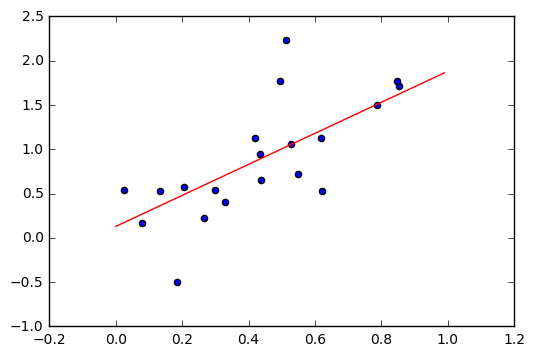

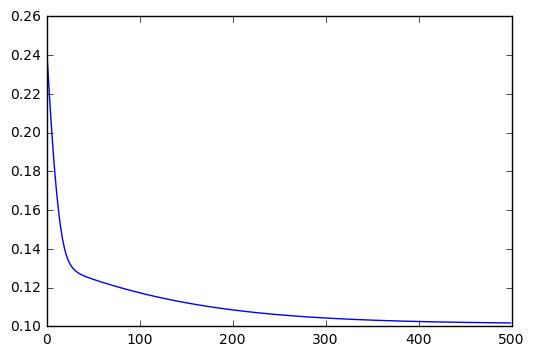

In [4]:
do_fitting(1, steps=500)

(4, 100)
(4, 1)
(100, 1)
0.100371


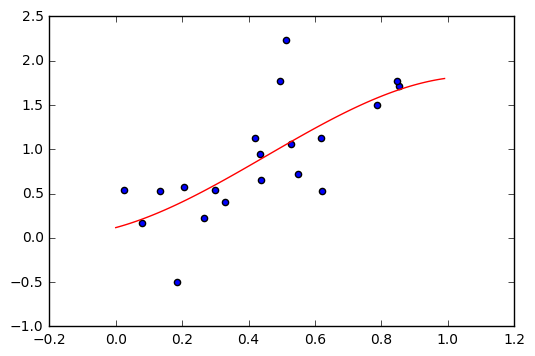

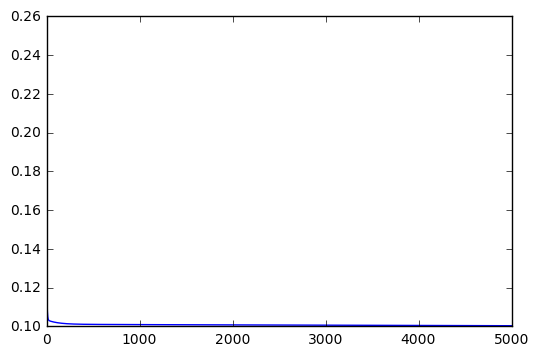

In [5]:
do_fitting(3, lr=1e-1, steps=5000)

(21, 100)
(21, 1)
(100, 1)
0.102814


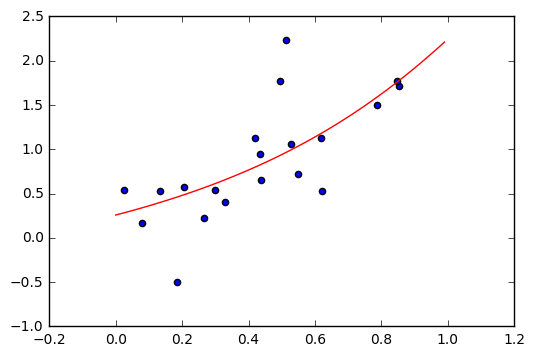

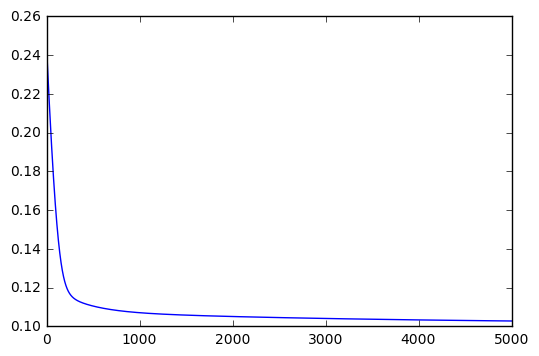

In [6]:
do_fitting(20, lr=1e-3, steps=5000)

In [4]:
s = 10
while s <= 100000:
    print
    print "%d steps" % (s,)
    %timeit -r 3 do_fitting(1, lr=0.1, steps=s, verbose=False)
    
    s *= 10


10 steps
The slowest run took 5.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.69 ms per loop

100 steps
100 loops, best of 3: 16.6 ms per loop

1000 steps
1 loop, best of 3: 256 ms per loop

10000 steps
1 loop, best of 3: 2.73 s per loop

100000 steps
1 loop, best of 3: 27.3 s per loop


In [1]:
blas.dtype = np.dtype([('BLAS', np.float32)])

def monkeypatch_method(cls, func, enforce):
    def wrap_in_numpy(*args, **kwargs):
        x = np.array(func(*args, **kwargs), copy=False, dtype=blas.dtype)
        return x
    
    def test_types(*args, **kwargs):
        original = cls.monkeypatch[func.__name__]
        args = list(args)

        for i, arg in enumerate(args):
            if i not in enforce:
                continue
                
            istype = type(arg) == blas.Variable
            
            # Cast to blas variable if it is a numpy vector!
            if not istype and (type(arg) == np.ndarray and arg.dtype == blas.dtype):
                args[i] = blas.Variable(arg.shape, 0)
                np.array(args[i], copy=False)[:] = arg
                istype = True
            
            
            if not istype:
                return original(*args, **kwargs)
        
        return wrap_in_numpy(*args, **kwargs)


    if 'monkeypatch' not in dir(cls):
        cls.monkeypatch = {}

    if func.__name__ not in cls.monkeypatch:
        cls.monkeypatch[func.__name__] = getattr(cls, func.__name__)
    
    setattr(cls, func.__name__, test_types)

    return cls.monkeypatch


from collections import OrderedDict

monkeypatch_method(np, blas.sqrt, (0,))
monkeypatch_method(np, blas.power, (0,))
monkeypatch_method(np, blas.sum, (0,))

with autodiff.Tape() as tape:
    sq = np.sqrt(blas.Variable((1,1), 4))
    pw = np.power(sq, 3)
    sm = np.sum(pw)
    
    print sq, sq.shape, sq.dtype
    print pw, pw.shape, pw.dtype
    print sm, sm.shape, sm.dtype

NameError: name 'np' is not defined